#     Neural Style Transfer

## Overview
Neural style transfer is an optimization technique used to take three images, a **content** image, a **style** image (such as an artwork by a famous painter), and a **generated** image -- and blend them together such that the generated image is transformed to **look like the content image, but “painted” in the style of the style image.**

The **key idea** behind Neural Style Transfer is that the **representations of content and style in the Convolutional Neural Network are separable**. That is, we can manipulate both representations independently to produce new, perceptually meaningful images. To demonstrate this finding, we
generate images that mix the content and style representation from two different source images.

![nst-example.png](assets/nst-example.png)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; **Deep Learning, Not Magic!**

### The Process consists of following steps :
1. Loading + Preprocessing data
2. Creating our model
3. Setting up loss functions 
4. Run the feedback loop to optimize the loss function using gradient descent

### 1. Loading + Preprocessing data

Loading dependencies

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import time
import functools

In [2]:
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

Specifying the content and style image path

In [3]:
content_path = 'content.jpg'
style_path = 'style.jpg'

Loading + displaying the image

In [4]:
def load_img(path_to_img):
  '''
        This function takes in the path of an image to be loaded, opens it as an Image object,
        resizes it along the bigger dimension of image, converts it into a nd-numpy array.
    
        Arguments:
            path_to_img : path of the image to be loaded
            
        Returns :
            A numpy nd-array object reshaped along the bigger dimension 
  '''
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.Resampling.LANCZOS)
  
  img = image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

In [5]:
def imshow(img, title=None):
  '''
        This function takes in an image object to be displayed and the corresponding title,
        and displays the image.
        
        Arguments:
            img : Image to be shown
            title : title of the displayed image
  '''
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

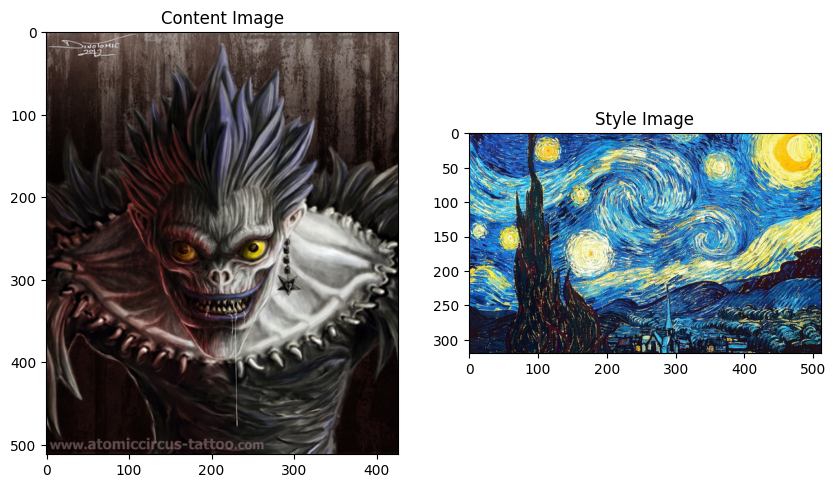

In [6]:
'''
    driver code to load + display the content and style images
'''

plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

Loading and Processing the image

In [7]:
def load_and_process_img(path_to_img):
  '''
      This function preprocesses the image encoding a batch of images(specified for vgg model).
      i.e. each channel normalized by mean=[103.939, 116.779, 123.68] and with channels BGR.
      
      Arguments : 
          path_to_img : path to the image to be preprocessed
          
      Returns : 
          img : preprocessed image
  '''
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [8]:
def deprocess_img(processed_img):
  '''
      This function performs the inverse of preprocessing step.
      In order to view the outputs, it is necessary to reverse all the operations
      performed during preprocessing step.
      Also the generated image may take values between -INF to INF, so we've to clip that down.
      
      Arguments : 
          processed_img : An image which has the preprocessing operations performed on it
          
      Returns : 
          x : Image object with all the deprocessing operations applied on it
  '''
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

## 2.Creating our Model
### Specifying the Content and Style Layers
To get the style and content feature maps of our images, we specify some layers of VGG19 model.
VGG19 is an image classification model, and as we go from the middle to the end layers, it captures higher order features of the images. 

In [21]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

content_layers = ['block5_conv2'] 

len_content_layers = len(content_layers)
len_style_layers = len(style_layers)
layer_names = content_layers+style_layers

### Get features

In [11]:
full_vgg = tf.keras.applications.vgg19.VGG19(include_top = False,
                                             weights = 'imagenet')


full_vgg.trainable = False

In [12]:
def get_submodel(vgg):
    '''
        This function takes in the entire vgg model and creates a submodel
        consisting of layers specified for style and content
    '''
    
    outputs = [vgg.get_layer(layer).output for layer in layer_names]

    
    model = tf.keras.Model(vgg.input, outputs)
    return model

In [13]:
def get_features(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  

  style_features = [style_layer[0] for style_layer in style_outputs[:len_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[len_style_layers:]]


  return style_features, content_features

## 3.Setting up loss functions

### content loss

In [14]:
def get_content_cost(gen_content, target_content):
  """
    returns the mean squared error between content of style and generated images
  """
  return tf.reduce_mean(tf.square(gen_content - target_content))

### Gram Matrix

In [15]:
def gram_matrix(input_tensor):
  '''
    returns the multiplication of input tensor with its transpose(gram matrix) 
  '''

  #flattening a multidimensional tensor into a 2d tensor
  #each row represents a specific style channel
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
    
    
  #calculating gram matrix
  n = tf.shape(a)[0]
  gram = tf.matmul(a,a,transpose_a=True)
    
  return gram / tf.cast(n, tf.float32)


### Style cost

In [16]:
def get_style_cost(gen_style, target_style):
  """Expects two images of dimension h, w, c"""

  
  height, width, channels = gen_style.get_shape().as_list()

  #calculating gram matrix of generated style
  gen_style = gram_matrix(gen_style)
  
  return tf.reduce_mean(tf.square(gen_style - target_style)) / (4.) #* (channels ** 2) * (width * height) ** 2)

### Total Loss

In [17]:
def compute_cost(model, gen_image, style_features, content_features,hyperparameters,):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """


  beta, alpha = hyperparameters
    
    
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  GI_features = model(gen_image)
  
  style_features_GI = GI_features[:len_style_layers]
  content_features_GI = GI_features[len_style_layers:]
  


  style_cost = 0
  content_cost = 0


  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(len_style_layers)
    
  for target_style, generated_style in zip(style_features, style_features_GI):
    style_cost += weight_per_style_layer * get_style_cost(generated_style[0], target_style)
    
    
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(len_content_layers)
    
  for target_content, generated_content in zip(content_features, content_features_GI):
    content_cost += weight_per_content_layer* get_content_cost(generated_content[0], target_content)
  
  content_cost *= alpha
  style_cost *= beta


  # Get total loss
  cost = style_cost + content_cost
  return cost, style_cost, content_cost

In [18]:
def compute_grads(config):
  '''
    performs backpropagation
  '''
  with tf.GradientTape() as tape: 
    all_cost = compute_cost(**config)
  
  total_cost = all_cost[0]
  return tape.gradient(total_cost, config['gen_image']), all_cost

## 4.Feedback Loop

In [19]:
import IPython.display

def neural_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       alpha=1e4, 
                       beta=1,
                       learning_rate=5,
                       epsilon=1e-1): 
 
  '''
  This function will run the central NST loop.
  
  Arguments:
    content_path:   path of the image which is to be used as content
    syle_path:      path of the image which is to be used as style
    num_iterations : no. of times the images are to be processed 
    alpha :         weight of the content loss while calculating total loss
    beta :          weight of the style loss while calculating total loss
    learning_rate : learning rate for backpropagation
    epsilong      : epsilon value for Adam optimizer
      
  Returns:
    returns the image with minimum loss and displays image after each 100 iteration
  
  '''
      
  model = get_submodel(full_vgg) 
  for layer in model.layers:
    layer.trainable = False
  

 
  style_features, content_features = get_features(model, content_path, style_path)
  style_features = [gram_matrix(style_feature) for style_feature in style_features]

    
    
    
  #initialize generated image
  gen_image = load_and_process_img(content_path)
  gen_image = tf.Variable(gen_image, dtype=tf.float32)


  # initialize Gradient Descent optimizer

  optimizer =  tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)


  
  # Store our best result
  best_img,best_loss = None,float("inf")
    
  
  # 
  config = {
      'model': model,
      'gen_image': gen_image,
      'style_features': style_features,
      'content_features': content_features,
      'hyperparameters': (beta, alpha)
  }
  


  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  

  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(config)
    
    loss, style_loss, content_loss = all_loss
    
    optimizer.apply_gradients([(grads, gen_image)])
    
    
    clipped = tf.clip_by_value(gen_image, min_vals, max_vals)
    gen_image.assign(clipped)

    
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(gen_image.numpy())

    if i % 100== 0:
      
      plot_img = gen_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)

      IPython.display.display_png(Image.fromarray(plot_img))
        
      print(f'Iteration: {i}')        
      print(f'Total loss: {loss} style loss: {style_loss} content loss: {content_loss} ')

      
  return best_img

In [ ]:
num_iterations=5000
alpha=1e4 
beta=1
learning_rate = 5
epsilon = 1e-1



best_img = neural_style_transfer(content_path, 
                          style_path,
                          num_iterations=num_iterations,
                          alpha=alpha,
                          beta=beta,
                          learning_rate=learning_rate,
                          epsilon=epsilon)

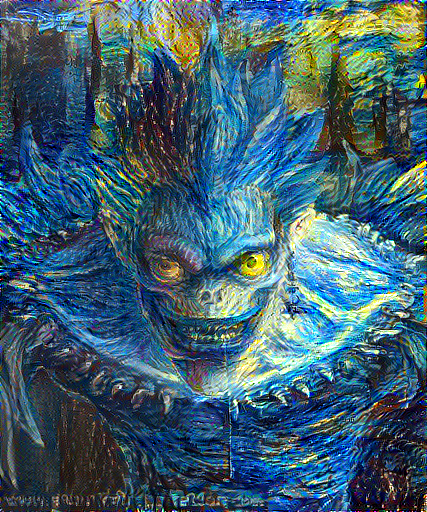

In [23]:
Image.fromarray(best_img)